In [1]:
print("Hello RAG!")

Hello RAG!


In [2]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI  

load_dotenv()
api_key = os.environ.get("OPENAI_API_KEY")

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    openai_api_key=api_key
)

# 이렇게 api_key를 불러오셔서 작업해주세요! 


c:\Users\user\anaconda3\envs\ds6_RAG_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
!pip install requests pandas python-dotenv

In [13]:
import pandas as pd
import os

# 1. 파일 이름 (아까 바꾸신 이름)
file_name = 'data.csv'
current_path = os.getcwd()
target_file = os.path.join(current_path, file_name)

# 2. 인코딩 후보들
encodings = ['cp949', 'euc-kr', 'utf-8-sig', 'utf-8']

df = None

# 3. 읽기 시도
for enc in encodings:
    try:
        print(f"🔄 {enc} 방식으로 읽기 시도 중...")
        df = pd.read_csv(target_file, encoding=enc)
        print(f"✅ {enc} 방식으로 로드 성공!")
        break
    except Exception as e:
        continue

if df is None:
    print("❌ 모든 인코딩 방식으로도 읽기에 실패했습니다. 파일이 깨졌거나 형식이 다를 수 있습니다.")
else:
    try:
        # 4. 챗봇용 데이터 가공
        # 우리가 필요한 건 '표준명'과 '기원명'입니다.
        if '표준명' in df.columns and '기원명' in df.columns:
            # 상위 1000개 데이터만 지식으로 만듭니다.
            df['knowledge'] = "성분명: " + df['표준명'].astype(str) + " | 설명: " + df['기원명'].astype(str)
            
            # data 폴더 생성 및 저장
            if not os.path.exists('data'): os.makedirs('data')
            df['knowledge'].head(1000).to_csv('data/ingredients_knowledge.txt', index=False, header=False, encoding='utf-8')
            
            print("📂 'data/ingredients_knowledge.txt' 생성이 완료되었습니다!")
            print(f"📊 추출된 데이터 개수: {len(df.head(1000))}개")
            print("🚀 이제 진짜 챗봇 엔진(Vector DB)을 만들 준비가 끝났습니다!")
        else:
            print(f"🚨 파일에 '표준명'이나 '기원명' 컬럼이 없습니다. 실제 컬럼명: {df.columns.tolist()}")

    except Exception as e:
        print(f"🚨 가공 중 에러 발생: {e}")

🔄 cp949 방식으로 읽기 시도 중...
🔄 euc-kr 방식으로 읽기 시도 중...
🔄 utf-8-sig 방식으로 읽기 시도 중...
🔄 utf-8 방식으로 읽기 시도 중...
❌ 모든 인코딩 방식으로도 읽기에 실패했습니다. 파일이 깨졌거나 형식이 다를 수 있습니다.


In [14]:
import pandas as pd

try:
    # CSV가 아니라 엑셀 엔진으로 강제 시도
    df = pd.read_excel('data.csv', engine='openpyxl')
    print("✅ 성공: 이 파일은 사실 엑셀 파일이었습니다!")
except Exception as e:
    print(f"❌ 엑셀로 읽기도 실패: {e}")

c:\Users\user\anaconda3\envs\ds6_RAG_2\lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


✅ 성공: 이 파일은 사실 엑셀 파일이었습니다!


In [15]:
import os

# 1. 챗봇이 공부하기 좋게 문장으로 만들기
# 엑셀의 컬럼명을 확인해보세요. (아마 '표준명', '기원명'일 겁니다)
# 만약 컬럼명이 다르다면 아래 코드를 그 이름으로 수정하세요.
df['knowledge'] = "성분명: " + df['표준명'].astype(str) + " | 설명: " + df['기원명'].astype(str)

# 2. data 폴더 생성 및 저장
if not os.path.exists('data'): 
    os.makedirs('data')

# 텍스트 파일로 내보내기
df['knowledge'].head(1000).to_csv('data/ingredients_knowledge.txt', index=False, header=False, encoding='utf-8')

print("✅ 'data/ingredients_knowledge.txt' 생성 완료! 이제 챗봇이 공부할 준비가 됐습니다.")

✅ 'data/ingredients_knowledge.txt' 생성 완료! 이제 챗봇이 공부할 준비가 됐습니다.


In [16]:
from langchain_community.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from dotenv import load_dotenv

load_dotenv()

# 1. 지식 불러오기
loader = TextLoader("data/ingredients_knowledge.txt", encoding='utf-8')
docs = loader.load()

# 2. 의미 단위로 쪼개기 (성분 설명 문맥을 유지하기 위해 SemanticChunker 사용)
embeddings = OpenAIEmbeddings()
text_splitter = SemanticChunker(embeddings)
splits = text_splitter.split_documents(docs)

# 3. 벡터 저장소(내 컴퓨터 지식 창고) 구축
vectorstore = Chroma.from_documents(
    documents=splits, 
    embedding=embeddings,
    persist_directory="./cosmetic_db"
)

# 4. 챗봇 모델 설정 (가장 가성비 좋은 gpt-4o-mini 추천)
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# 5. 질문-답변 체인 생성
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(search_kwargs={"k": 3})
)

print("🔥 '먹지말고 피부에 양보해RAG' 챗봇 가동 중!")

# 6. 실제 테스트
question = "병풀추출물에 대해서 설명해줘."
response = qa_chain.invoke(question)

print(f"\n💬 질문: {question}")
print(f"🤖 답변: {response['result']}")

c:\Users\user\anaconda3\envs\ds6_RAG_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔥 '먹지말고 피부에 양보해RAG' 챗봇 가동 중!

💬 질문: 병풀추출물에 대해서 설명해줘.
🤖 답변: 병풀추출물은 병풀 (Centella asiatica)의 전초에서 추출한 원료입니다.


In [1]:
pip install openai pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openai pillow python-dotenv pillow-avif-plugin

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.9 MB 24.6 MB/s eta 0:00:01
   ----------------- ---------------------- 4.2/9.9 MB 12.0 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.9 MB 10.0 MB/s eta 0:00:01
   ---------------------------- ----------- 7.1/9.9 MB 8.4 MB/s eta 0:00:01
   -------------------------------------- - 9.4/9.9 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 8.9 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
import base64
import io
from PIL import Image
from openai import OpenAI
from dotenv import load_dotenv

# 1. 환경 설정
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def extract_raw_text(image_path, num_splits=8):
    """
    이미지를 8등분하여 보이는 모든 텍스트를 있는 그대로 추출합니다.
    """
    if not os.path.exists(image_path):
        print(f"❌ 파일을 찾을 수 없습니다: {image_path}")
        return

    img = Image.open(image_path)
    width, height = img.size
    split_height = height // num_splits
    
    full_transcript = []

    print(f"🚀 총 {num_splits}개 구역에서 텍스트 추출을 시작합니다.")

    for i in range(num_splits):
        top = i * split_height
        bottom = (i + 1) * split_height if i < num_splits - 1 else height
        chunk = img.crop((0, top, width, bottom))
        
        # 이미지 변환
        buffered = io.BytesIO()
        chunk.convert("RGB").save(buffered, format="JPEG")
        base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
        
        print(f"  - [{i+1}/{num_splits}] 구역 글자 읽는 중...")
        
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text", 
                                "text": "이 이미지 조각에 적힌 모든 글자를 보이는 그대로 빠짐없이 정보를 추출해서 정리해줘. 요약하거나 항목을 나누지 말고, 있는 그대로의 텍스트만 나열해줘."
                            },
                            {
                                "type": "image_url",
                                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
                            },
                        ],
                    }
                ],
                max_tokens=1000,
            )
            raw_text = response.choices[0].message.content
            if raw_text.strip():
                full_transcript.append(raw_text)
        except Exception as e:
            print(f"  ⚠️ {i+1}번 구역 에러: {e}")

    return "\n\n".join(full_transcript)

# --- 실행부 ---
input_image = "optimize.avif" 
output_file = "data/raw_extracted_text.txt"

os.makedirs("data", exist_ok=True)
final_result = extract_raw_text(input_image)

if final_result:
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(final_result)
    print("-" * 30)
    print("✅ 추출 완료! 이미지의 모든 텍스트가 저장되었습니다.")
    print(f"결과 확인: {output_file}")

🚀 총 8개 구역에서 텍스트 추출을 시작합니다.
  - [1/8] 구역 글자 읽는 중...
  - [2/8] 구역 글자 읽는 중...
  - [3/8] 구역 글자 읽는 중...
  - [4/8] 구역 글자 읽는 중...
  - [5/8] 구역 글자 읽는 중...
  - [6/8] 구역 글자 읽는 중...
  - [7/8] 구역 글자 읽는 중...
  - [8/8] 구역 글자 읽는 중...
------------------------------
✅ 추출 완료! 이미지의 모든 텍스트가 저장되었습니다.
결과 확인: data/raw_extracted_text.txt


In [2]:
import os
import base64
import io
import time
from PIL import Image
from openai import OpenAI
from dotenv import load_dotenv

# 1. 환경 설정 및 클라이언트 초기화
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def process_and_extract(image_path, num_splits=8):
    """이미지를 8등분하여 모든 텍스트를 추출하는 함수"""
    img = Image.open(image_path)
    width, height = img.size
    split_height = height // num_splits
    
    extracted_texts = []

    for i in range(num_splits):
        top = i * split_height
        bottom = (i + 1) * split_height if i < num_splits - 1 else height
        chunk = img.crop((0, top, width, bottom))
        
        # 이미지 변환 (RGB 변환 후 JPEG로 인코딩)
        buffered = io.BytesIO()
        chunk.convert("RGB").save(buffered, format="JPEG")
        base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
        
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text", 
                                "text": "이 이미지 조각에 적힌 모든 글자를 보이는 그대로 빠짐없이 추출해줘. 요약하지 말고 있는 그대로의 텍스트만 나열해줘."
                            },
                            {
                                "type": "image_url",
                                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}
                            },
                        ],
                    }
                ],
                max_tokens=1000,
            )
            text = response.choices[0].message.content
            if text.strip():
                extracted_texts.append(text)
        except Exception as e:
            print(f"      ⚠️ 구역 {i+1} 에러 발생: {e}")
            
    return "\n\n".join(extracted_texts)

def main():
    # 수정 전: base_path = "ds6_rag"
    # 수정 후: VS Code 탐색기 기준 최상위에 폴더들이 있으므로 빈 값으로 설정합니다.
    base_path = "" 
    
    image_dir = "images"       # 이미지가 들어있는 폴더명
    output_dir = "text_data"   # 텍스트를 저장할 폴더명

    # 결과 폴더가 없으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 지원하는 이미지 확장자
    valid_extensions = ('.jpg', '.jpeg', '.png', '.avif', '.webp')
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]

    print(f"🚀 총 {len(image_files)}개의 이미지를 처리하기 시작합니다.")

    for idx, filename in enumerate(image_files):
        print(f"[{idx+1}/{len(image_files)}] 현재 작업 중: {filename}")
        
        img_path = os.path.join(image_dir, filename)
        # 확장자를 뺀 파일 이름으로 txt 파일명 생성 (예: 회사명_제품명.txt)
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(output_dir, txt_filename)

        # 이미 추출된 파일이 있다면 건너뛰기 (시간 절약)
        if os.path.exists(txt_path):
            print(f"  ⏭️ 이미 완료된 파일입니다. 건너뜁니다.")
            continue

        # 텍스트 추출 실행
        result_text = process_and_extract(img_path)
        
        # 파일 저장
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(result_text)
        
        print(f"  ✅ 추출 및 저장 완료: {txt_filename}")
        
        # API 과부하 방지 및 안정성을 위한 짧은 휴식
        time.sleep(0.5)

    print("\n🎉 모든 이미지의 텍스트 추출 작업이 끝났습니다!")

if __name__ == "__main__":
    main()

🚀 총 40개의 이미지를 처리하기 시작합니다.
[1/40] 현재 작업 중: CNPbyeod-td_스팟카밍젤10ml.avif
  ✅ 추출 및 저장 완료: CNPbyeod-td_스팟카밍젤10ml.txt
[2/40] 현재 작업 중: VT_리들샷100페이셜부스팅퍼스트앰플.avif
  ✅ 추출 및 저장 완료: VT_리들샷100페이셜부스팅퍼스트앰플.txt
[3/40] 현재 작업 중: VT_리들샷300페이셜부스팅퍼스트앰플.avif
  ✅ 추출 및 저장 완료: VT_리들샷300페이셜부스팅퍼스트앰플.txt
[4/40] 현재 작업 중: VT_리들샷500페이셜부스팅퍼스트앰플.avif
  ✅ 추출 및 저장 완료: VT_리들샷500페이셜부스팅퍼스트앰플.txt
[5/40] 현재 작업 중: VT_리들샷페이셜레디언스글루타치온에센스.avif
  ✅ 추출 및 저장 완료: VT_리들샷페이셜레디언스글루타치온에센스.txt
[6/40] 현재 작업 중: VT_리들샷페이셜리페어EGF에센스.avif
  ✅ 추출 및 저장 완료: VT_리들샷페이셜리페어EGF에센스.txt
[7/40] 현재 작업 중: VT_리들샷페이셜리프팅펩타이드에센스.avif
  ✅ 추출 및 저장 완료: VT_리들샷페이셜리프팅펩타이드에센스.txt
[8/40] 현재 작업 중: VT_시카카밍크림50ml.avif
  ✅ 추출 및 저장 완료: VT_시카카밍크림50ml.txt
[9/40] 현재 작업 중: VT_콜라겐리들샷S50페이셜부스팅퍼스트앰플.avif
  ✅ 추출 및 저장 완료: VT_콜라겐리들샷S50페이셜부스팅퍼스트앰플.txt
[10/40] 현재 작업 중: VT_프로시카리들샷S50페이셜부스팅퍼스트앰플.avif
  ✅ 추출 및 저장 완료: VT_프로시카리들샷S50페이셜부스팅퍼스트앰플.txt
[11/40] 현재 작업 중: 과일나라_알로에베라모이스처아쿠아수딩젤미스트310ml.avif
  ✅ 추출 및 저장 완료: 과일나라_알로에베라모이스처아쿠아수딩젤미스트310ml.txt
[12/40] 현재 작업 중: 김정문알로에_라센스로에큐어인텐시브2X크림30g.av

In [1]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# DB 로드
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = Chroma(persist_directory="./cosmetic_db", embedding_function=embeddings)

# 저장된 메타데이터에서 파일 목록 추출
data = vectorstore.get()
sources = set([meta['source'] for meta in data['metadatas']])

print(f"📊 현재 DB에 저장된 고유 파일 개수: {len(sources)}개")
print("📂 파일 목록:")
for s in sorted(list(sources)):
    print(f" - {s}")

c:\Users\user\anaconda3\envs\ds6_RAG_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\AppData\Local\Temp\ipykernel_17716\4023435868.py:6: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory="./cosmetic_db", embedding_function=embeddings)


📊 현재 DB에 저장된 고유 파일 개수: 41개
📂 파일 목록:
 - data/ingredients_knowledge.txt
 - text_data\CNPbyeod-td_스팟카밍젤10ml.txt
 - text_data\VT_리들샷100페이셜부스팅퍼스트앰플.txt
 - text_data\VT_리들샷300페이셜부스팅퍼스트앰플.txt
 - text_data\VT_리들샷500페이셜부스팅퍼스트앰플.txt
 - text_data\VT_리들샷페이셜레디언스글루타치온에센스.txt
 - text_data\VT_리들샷페이셜리페어EGF에센스.txt
 - text_data\VT_리들샷페이셜리프팅펩타이드에센스.txt
 - text_data\VT_시카카밍크림50ml.txt
 - text_data\VT_콜라겐리들샷S50페이셜부스팅퍼스트앰플.txt
 - text_data\VT_프로시카리들샷S50페이셜부스팅퍼스트앰플.txt
 - text_data\과일나라_알로에베라모이스처아쿠아수딩젤미스트310ml.txt
 - text_data\김정문알로에_라센스로에큐어인텐시브2X크림30g.txt
 - text_data\닥터오라클_큐어소나래디언스글로우앰플40ml.txt
 - text_data\더랩바이블랑두_클리어히알물광부스터앰플30ml.txt
 - text_data\더랩바이블랑두_클리어히알물광크림50ml.txt
 - text_data\드롭비_모공촘촘앰플40ml.txt
 - text_data\드롭비_잡티말끔앰플40ml.txt
 - text_data\드롭비_탄탄광채앰플40ml.txt
 - text_data\마데카21_테카솔루션수딩미스트토너200ml.txt
 - text_data\마데카21_테카솔루션수딩스팟젤15ml.txt
 - text_data\마데카21_테카솔루션수딩캡슐앰플30ml.txt
 - text_data\마데카21_테카솔루션수딩크림50ml.txt
 - text_data\마데카21_테카토닝스팟에센스15ml.txt
 - text_data\마데카21_테카토닝캡슐세럼30ml.txt
 - text_data\마데카

In [3]:
import os
import glob
import base64
import requests
from dotenv import load_dotenv

# 1. 환경 변수 및 API 키 로드
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

# 2. 이미지를 base64로 인코딩하는 함수
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# 3. GPT-4o Vision API를 사용한 OCR 함수
def extract_text_from_image_with_gpt4o(image_path, api_key):
    base64_image = encode_image(image_path)

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "이 이미지에 있는 모든 텍스트를 추출해줘. 특히 제품의 전성분, 효능/효과, 임상 시험 결과(수치 포함)를 빠짐없이 정확하게 적어줘. 오타가 보이면 문맥에 맞게 수정해서 적어줘."},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                ]
            }
        ],
        "max_tokens": 2000
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()['choices'][0]['message']['content']

In [4]:
# 경로 설정
image_dir = "./images"
text_dir = "./text_data"
os.makedirs(text_dir, exist_ok=True) # 폴더가 없으면 생성

# 1. 모든 이미지 파일 목록 가져오기 (확장자 무관)
all_images = []
for ext in ['*.jpg', '*.jpeg', '*.png', '*.avif']:
    all_images.extend(glob.glob(os.path.join(image_dir, ext)))

# 2. 이미 변환된 txt 파일 이름(확장자 제외) 가져오기
existing_txt_names = set(
    os.path.splitext(os.path.basename(f))[0]
    for f in glob.glob(os.path.join(text_dir, "*.txt"))
)

# 3. 누락된 이미지 식별
missing_images = []
for img_path in all_images:
    img_name_no_ext = os.path.splitext(os.path.basename(img_path))[0]
    if img_name_no_ext not in existing_txt_names:
        missing_images.append(img_path)

print(f"📊 전체 이미지 파일: {len(all_images)}개")
print(f"✅ 변환 완료된 TXT: {len(existing_txt_names)}개")
print(f"🆕 변환 대상(누락) 이미지: {len(missing_images)}개")

# 4. 누락된 이미지에 대해 OCR 수행 및 저장
newly_created_txts = []
for i, img_path in enumerate(missing_images):
    img_name = os.path.basename(img_path)
    txt_name = os.path.splitext(img_name)[0] + ".txt"
    txt_path = os.path.join(text_dir, txt_name)

    print(f"[{i+1}/{len(missing_images)}] OCR 처리 중: {img_name}...")
    try:
        extracted_text = extract_text_from_image_with_gpt4o(img_path, api_key)
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(extracted_text)
        print(f"  -> 저장 완료: {txt_path}")
        newly_created_txts.append(txt_path)
    except Exception as e:
        print(f"  ❌ 에러 발생 ({img_name}): {e}")

📊 전체 이미지 파일: 50개
✅ 변환 완료된 TXT: 40개
🆕 변환 대상(누락) 이미지: 10개
[1/10] OCR 처리 중: VT_시카카밍토너300ml.avif...
  ❌ 에러 발생 (VT_시카카밍토너300ml.avif): 'choices'
[2/10] OCR 처리 중: 김정문알로에_큐어알파알로에시카수딩젤150ml.avif...
  ❌ 에러 발생 (김정문알로에_큐어알파알로에시카수딩젤150ml.avif): 'choices'
[3/10] OCR 처리 중: 김정문알로에_큐어알파카밍알로에크림50g.avif...
  ❌ 에러 발생 (김정문알로에_큐어알파카밍알로에크림50g.avif): 'choices'
[4/10] OCR 처리 중: 닥터오라클_큐어소나리쥬코드롤러앰플30ml.avif...
  ❌ 에러 발생 (닥터오라클_큐어소나리쥬코드롤러앰플30ml.avif): 'choices'
[5/10] OCR 처리 중: 닥터오라클_큐어소나리커버링릴렉싱크림60ml.avif...
  ❌ 에러 발생 (닥터오라클_큐어소나리커버링릴렉싱크림60ml.avif): 'choices'
[6/10] OCR 처리 중: 랩팩토리_멀티밤9g주름스틱.avif...
  ❌ 에러 발생 (랩팩토리_멀티밤9g주름스틱.avif): 'choices'
[7/10] OCR 처리 중: 메디필_멜라논엑스기미크림30ml.avif...
  ❌ 에러 발생 (메디필_멜라논엑스기미크림30ml.avif): 'choices'
[8/10] OCR 처리 중: 바이리얼베리어_세라베이스카밍모이스처라이징크림50ml.avif...
  ❌ 에러 발생 (바이리얼베리어_세라베이스카밍모이스처라이징크림50ml.avif): 'choices'
[9/10] OCR 처리 중: 채비공간_병풀추출물비건토너150ml.avif...
  ❌ 에러 발생 (채비공간_병풀추출물비건토너150ml.avif): 'choices'
[10/10] OCR 처리 중: 클리덤(종근당건강)_저분자콜라겐미스트앰플100ml.avif...
  ❌ 에러 발생 (클리덤(종근당건강)_저분자콜라겐미스트

In [5]:
pip install pillow pillow-avif-plugin

Note: you may need to restart the kernel to use updated packages.


In [6]:
import io
from PIL import Image
import pillow_avif # AVIF 지원을 위해 꼭 필요합니다.

def encode_image(image_path):
    # Pillow를 사용하여 이미지를 엽니다.
    with Image.open(image_path) as img:
        # AVIF 등 지원되지 않는 형식을 위해 RGB 모드의 JPEG로 변환합니다.
        img = img.convert("RGB")
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG")
        # 변환된 JPEG 데이터를 base64로 인코딩합니다.
        return base64.b64encode(buffer.getvalue()).decode('utf-8')

# OCR 함수(extract_text_from_image_with_gpt4o)는 그대로 사용하시되,
# 내부에서 위에서 수정한 encode_image를 호출하도록 두시면 됩니다.

In [7]:
# 아까 실패했던 리스트를 다시 처리합니다.
for i, img_path in enumerate(missing_images):
    img_name = os.path.basename(img_path)
    txt_name = os.path.splitext(img_name)[0] + ".txt"
    txt_path = os.path.join(text_dir, txt_name)

    print(f"[{i+1}/{len(missing_images)}] 변환 및 OCR 처리 중: {img_name}...")
    try:
        # 수정된 encode_image가 내부에서 호출됨
        extracted_text = extract_text_from_image_with_gpt4o(img_path, api_key)
        
        with open(txt_path, "w", encoding="utf-8") as f:
            f.write(extracted_text)
        print(f"  -> 저장 완료: {txt_path}")
        
    except Exception as e:
        print(f"  ❌ 에러 발생 ({img_name}): {e}")
        # 만약 여전히 'choices' 에러가 난다면 response.json()을 찍어서 확인해야 합니다.

[1/10] 변환 및 OCR 처리 중: VT_시카카밍토너300ml.avif...
  -> 저장 완료: ./text_data\VT_시카카밍토너300ml.txt
[2/10] 변환 및 OCR 처리 중: 김정문알로에_큐어알파알로에시카수딩젤150ml.avif...
  -> 저장 완료: ./text_data\김정문알로에_큐어알파알로에시카수딩젤150ml.txt
[3/10] 변환 및 OCR 처리 중: 김정문알로에_큐어알파카밍알로에크림50g.avif...
  -> 저장 완료: ./text_data\김정문알로에_큐어알파카밍알로에크림50g.txt
[4/10] 변환 및 OCR 처리 중: 닥터오라클_큐어소나리쥬코드롤러앰플30ml.avif...
  -> 저장 완료: ./text_data\닥터오라클_큐어소나리쥬코드롤러앰플30ml.txt
[5/10] 변환 및 OCR 처리 중: 닥터오라클_큐어소나리커버링릴렉싱크림60ml.avif...
  -> 저장 완료: ./text_data\닥터오라클_큐어소나리커버링릴렉싱크림60ml.txt
[6/10] 변환 및 OCR 처리 중: 랩팩토리_멀티밤9g주름스틱.avif...
  -> 저장 완료: ./text_data\랩팩토리_멀티밤9g주름스틱.txt
[7/10] 변환 및 OCR 처리 중: 메디필_멜라논엑스기미크림30ml.avif...
  -> 저장 완료: ./text_data\메디필_멜라논엑스기미크림30ml.txt
[8/10] 변환 및 OCR 처리 중: 바이리얼베리어_세라베이스카밍모이스처라이징크림50ml.avif...
  -> 저장 완료: ./text_data\바이리얼베리어_세라베이스카밍모이스처라이징크림50ml.txt
[9/10] 변환 및 OCR 처리 중: 채비공간_병풀추출물비건토너150ml.avif...
  -> 저장 완료: ./text_data\채비공간_병풀추출물비건토너150ml.txt
[10/10] 변환 및 OCR 처리 중: 클리덤(종근당건강)_저분자콜라겐미스트앰플100ml.avif...
  -> 저장 완료: ./text_data\클리덤(종근당건강)_저분

In [3]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.prompts import ChatPromptTemplate

# 1. 환경 변수 로드
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

def build_initial_rag_model():
    # 2. 데이터 로드 (text_data 폴더 내 모든 txt 파일)
    print("📂 데이터를 불러오는 중...")
    loader = DirectoryLoader("./text_data", glob="*.txt", loader_cls=TextLoader)
    documents = loader.load()

    # 3. 텍스트 분할 (Chunking)
    # 이미지 추출 데이터라 오타나 끊김이 있을 수 있으므로 오버랩(overlap)을 넉넉히 줍니다.
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    texts = text_splitter.split_documents(documents)

    # 4. 임베딩 및 벡터 데이터베이스 생성
    print("🧠 데이터 벡터화 및 DB 구축 중 (Chroma)...")
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = Chroma.from_documents(documents=texts, embedding=embeddings, persist_directory="./cosmetic_db")

    # 5. 프롬프트 설정 (페르소나 부여)
    template = """귀하는 다이소 기초 화장품 전문 컨설턴트입니다. 
    제공된 문서는 다이소 제품의 상세페이지와 리뷰에서 추출된 텍스트입니다. 
    이미지에서 추출된 텍스트라 오타(예: '틱처' -> '틴처', '지극' -> '자극')가 있을 수 있으니 문맥에 따라 유연하게 이해하세요.

    질문: {question}
    관련 정보: {context}

    답변 가이드라인:
    1. 사용자의 피부 타입과 고민에 맞는 제품을 추천하세요.
    2. 추천 시 "이러한 성분(예: 시카, 티트리 등)이 들어있어 ~한 기능을 한다"는 점을 문서에 기반해 설명하세요.
    3. 문서에 없는 내용은 억지로 꾸며내지 마세요.
    4. 친절하고 전문적인 말투를 사용하세요.

    답변:"""
    
    prompt = ChatPromptTemplate.from_template(template)

    # 6. RAG 체인 구성
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.2)
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vectorstore.as_retriever(search_kwargs={"k": 3}), # 가장 관련성 높은 3개 구역 참조
        chain_type_kwargs={"prompt": prompt}
    )

    return qa_chain

# --- 실행 및 테스트 ---
if __name__ == "__main__":
    # 모델 빌드
    cosmetic_bot = build_initial_rag_model()
    
    # 사용자 질문 테스트
    user_query = "나는 지성피부인데 유분이 너무 많아. 유분을 잡고 싶은데 기초제품 추천해줘."
    print(f"\n💬 질문: {user_query}")
    
    response = cosmetic_bot.invoke(user_query)
    print(f"\n🤖 답변:\n{response['result']}")

c:\Users\user\anaconda3\envs\ds6_RAG_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📂 데이터를 불러오는 중...
🧠 데이터 벡터화 및 DB 구축 중 (Chroma)...

💬 질문: 나는 지성피부인데 유분이 너무 많아. 유분을 잡고 싶은데 기초제품 추천해줘.

🤖 답변:
지성 피부로 유분이 많아 고민이시군요. 이러한 피부 타입에는 수분 공급과 유분 조절이 중요한데, 다이소의 VT 진정 수분 시너지 제품을 추천드립니다.

이 제품은 진정 및 수분 공급에 효과적인 성분이 포함되어 있어, 예민해진 피부를 진정시키고 보습을 강화하는 데 도움을 줍니다. 특히, 유효 성분의 흡수가 원활하여 피부 개선에 효과적입니다.

또한, 하이드라 카밍 젤 클렌저와 비타 카밍 세럼을 함께 사용하시면 더욱 좋습니다. 하이드라 카밍 젤 클렌저는 부드럽게 세안하여 피부의 노폐물과 유분을 제거해주고, 비타 카밍 세럼은 피부를 촉촉하게 진정시켜 줍니다. 마지막으로, 하이드라 카밍 크림으로 수분을 잠궈주면 유분 조절에 도움이 될 것입니다.

이러한 제품들을 통해 지성 피부의 유분을 효과적으로 관리하고, 건강한 피부로 가꾸실 수 있기를 바랍니다!


In [4]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.prompts import ChatPromptTemplate

# 1. 환경 변수 로드
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

def build_initial_rag_model():
    # 2. 데이터 로드 (text_data 폴더 내 모든 txt 파일)
    print("📂 데이터를 불러오는 중...")
    loader = DirectoryLoader("./text_data", glob="*.txt", loader_cls=TextLoader)
    documents = loader.load()

    # 3. 텍스트 분할 (Chunking)
    # 이미지 추출 데이터라 오타나 끊김이 있을 수 있으므로 오버랩(overlap)을 넉넉히 줍니다.
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    texts = text_splitter.split_documents(documents)

    # 4. 임베딩 및 벡터 데이터베이스 생성
    print("🧠 데이터 벡터화 및 DB 구축 중 (Chroma)...")
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = Chroma.from_documents(documents=texts, embedding=embeddings, persist_directory="./cosmetic_db")

    # 5. 프롬프트 설정 (페르소나 부여)
    template = """귀하는 다이소 기초 화장품 전문 컨설턴트입니다. 
제공된 [참조 문서]를 바탕으로 사용자의 [피부 고민]에 맞춰 3가지 제품을 비교 추천하세요.

[답변 구조 가이드라인]
1. **첫 번째 추천: [제품명]**
   - **이유:** 문서에 기재된 구체적인 수치나 성분을 바탕으로 어떤 도움을 주는지 설명하세요.
2. **두 번째 추천: [제품명]**
   - **특징:** 어떤 성분이 들어있는지 언급하세요.
   - **차별점:** 첫 번째 제품과 비교했을 때 어떤 점이 다른지(제형, 주효능 등) 설명하고, 어떤 분께 더 적합한지 명시하세요.
3. **세 번째 추천: [제품명]**
   - **특징:** 위 제품들과는 또 다른 매력 포인트(예: 가성비, 특수 부위 케어 등)를 설명하세요.
4. **종합 결론**
   - "가장 추천드리는 베스트 아이템은 [제품명]입니다."로 시작하여 이유를 한 줄로 요약하며 마무리하세요.

[주의사항]
- 이미지 OCR 오타(예: 틱처->틴처)는 문맥에 맞게 교정하여 답변하세요.
- 상세페이지에 명시된 임상 수치(예: % 감소 등)가 있다면 반드시 포함하세요.

질문: {question}
참조 문서: {context}
    답변:"""
    
    prompt = ChatPromptTemplate.from_template(template)

    # 6. RAG 체인 구성
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.2)
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vectorstore.as_retriever(search_kwargs={"k": 3}), # 가장 관련성 높은 3개 구역 참조
        chain_type_kwargs={"prompt": prompt}
    )

    return qa_chain

# --- 실행 및 테스트 ---
if __name__ == "__main__":
    # 모델 빌드
    cosmetic_bot = build_initial_rag_model()
    
    # 사용자 질문 테스트
    user_query = "나는 지성피부인데 유분이 너무 많아. 유분을 잡고 싶은데 기초제품 추천해줘."
    print(f"\n💬 질문: {user_query}")
    
    response = cosmetic_bot.invoke(user_query)
    print(f"\n🤖 답변:\n{response['result']}")

📂 데이터를 불러오는 중...
🧠 데이터 벡터화 및 DB 구축 중 (Chroma)...

💬 질문: 나는 지성피부인데 유분이 너무 많아. 유분을 잡고 싶은데 기초제품 추천해줘.

🤖 답변:
1. **첫 번째 추천: VT 진정 수분 시너지 앰플**
   - **이유:** 이 제품은 진정 및 수분 공급에 효과적인 성분이 포함되어 있어, 지성 피부의 유분을 조절하고 수분을 보충하는 데 도움을 줍니다. 특히, 유효성분의 흡수가 원활하여 피부에 빠르게 스며들어 기름진 느낌을 줄여줍니다.

2. **두 번째 추천: 하이드라 카밍 젤 클렌저**
   - **특징:** 이 제품은 부드러운 젤 제형으로, 피부의 노폐물과 각질을 효과적으로 제거합니다. 
   - **차별점:** VT 진정 수분 시너지 앰플이 수분 공급에 중점을 둔 반면, 하이드라 카밍 젤 클렌저는 세안 단계에서 유분과 불순물을 제거하는 데 초점을 맞추고 있습니다. 따라서, 지성 피부로 인해 트러블이 잦은 분들에게 더 적합합니다.

3. **세 번째 추천: 블레미쉬 트리트먼트**
   - **특징:** 이 제품은 여드름과 같은 트러블 부위를 집중적으로 케어할 수 있는 스팟 트리트먼트입니다. 
   - **매력 포인트:** 가성비가 뛰어나며, 특정 부위에만 사용하여 효과를 극대화할 수 있어 지성 피부의 트러블 관리에 적합합니다. 

4. **종합 결론**
   - "가장 추천드리는 베스트 아이템은 VT 진정 수분 시너지 앰플입니다." 이 제품은 지성 피부의 유분을 조절하고 수분을 공급하여 건강한 피부로 가꾸는 데 가장 효과적입니다.


In [6]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import os

def run_full_evaluation(file_path):
    # 1. 엑셀 파일 읽기
    df = pd.read_excel(file_path)
    
    # 🔍 컬럼명 확인 (에러 방지용)
    print("현재 엑셀에 있는 컬럼들:", df.columns.tolist())
    
    # 2. 컬럼명 매칭 (규빈님의 엑셀 헤더와 똑같이 맞춰주세요)
    # 만약 엑셀 헤더가 '질문 (Input Query)'라면 아래처럼 수정합니다.
    col_name_question = "질문 (Input Query)" 
    col_name_constraints = "제약 조건 (Constraints)"

    results = []

    print(f"🚀 총 {len(df)}개의 데이터를 평가합니다.")

    for idx, row in df.iterrows():
        try:
            # 매칭된 컬럼명으로 데이터 가져오기
            question_text = row[col_name_question]
            constraints_text = row[col_name_constraints]
            
            print(f"[{idx+1}/{len(df)}] '{question_text[:15]}...' 처리 중")
            
            # --- 챗봇 답변 및 채점 로직 (기존과 동일) ---
            # answer = cosmetic_bot.invoke(question_text)['result']
            # eval_result = evaluate_daiso_bot(...)
            # ---------------------------------------
            
        except KeyError as e:
            print(f"❌ 컬럼명을 찾을 수 없습니다: {e}")
            print("위의 '현재 엑셀에 있는 컬럼들' 출력을 보고 코드를 수정하세요.")
            break

if __name__ == "__main__":
    actual_filename = "다이소 기초 화장품 골든 데이터셋(50문항).xlsx"
    run_full_evaluation(actual_filename)

현재 엑셀에 있는 컬럼들: ['ID', '카테고리', '질문 (Input Query)', '제약 조건 (Constraints)', '정답 가이드 (Ground Truth / 핵심 키워드)']
🚀 총 30개의 데이터를 평가합니다.
[1/30] '"유분이 너무 많아 고민인데...' 처리 중
[2/30] '"남성인데 피지가 폭발해. ...' 처리 중
[3/30] '"번들거리는 개기름은 잡고 ...' 처리 중
[4/30] '"여름에 쓰기 좋은 쿨링감 ...' 처리 중
[5/30] '"피지 조절 기능이 있는 약...' 처리 중
[6/30] '(유사한 유분/피지/산뜻함 ...' 처리 중
[7/30] '"마스크 때문에 볼이 붉고 ...' 처리 중
[8/30] '"피부가 예민해서 아무거나 ...' 처리 중
[9/30] '"좁쌀 여드름이 올라올 때 ...' 처리 중
[10/30] '"화장독 올라온 피부를 진정...' 처리 중
[11/30] '"티트리나 판테놀 성분이 들...' 처리 중
[12/30] '(유사한 홍조/자극/성분 중...' 처리 중
[13/30] '"피부가 너무 건조해서 찢어...' 처리 중
[14/30] '"밤사이 수분이 안 날아가게...' 처리 중
[15/30] '"히알루론산이 듬뿍 들어간 ...' 처리 중
[16/30] '"건성 피부인데 세안 후에 ...' 처리 중
[17/30] '"오일 타입보다는 수분감이 ...' 처리 중
[18/30] '(유사한 영양/속건조/장벽 ...' 처리 중
[19/30] '"블랙헤드랑 화이트헤드가 고...' 처리 중
[20/30] '"모공이 늘어져 보여서 탄력...' 처리 중
[21/30] '"리들샷 100이랑 300 ...' 처리 중
[22/30] '"피부 결이 거칠거칠해. 자...' 처리 중
[23/30] '"코 주변 모공 속에 피지가...' 처리 중
[24/30] '(유사한 스피큘/각질/모공 ...' 처리 중
[25/30] '"여드름 지나간 자리에 거뭇...' 처리 중
[26/30] '"나이아신아마이드 들어간 제...' 처리

In [3]:
import os
import glob
from dotenv import load_dotenv
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.prompts import ChatPromptTemplate

# 1. 환경 변수 로드
load_dotenv()

def update_rag_model_with_new_files():
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    persist_directory = "./cosmetic_db"
    data_path = "./text_data"

    # 2. 기존 벡터 DB 불러오기 (이미 40개가 저장된 상태)
    print("🔄 기존 벡터 DB 로드 중...")
    vectorstore = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

    # 3. 기존 DB에 저장된 파일(Source) 목록 확인
    existing_data = vectorstore.get()
    existing_sources = set()
    if existing_data['metadatas']:
        for meta in existing_data['metadatas']:
            existing_sources.add(os.path.normpath(meta['source']))

    # 4. 폴더 내 파일 중 새로 추가된 10개 파일만 식별
    all_files = glob.glob(os.path.join(data_path, "*.txt"))
    new_files = [f for f in all_files if os.path.normpath(f) not in existing_sources]

    if not new_files:
        print("✅ 새로 추가할 데이터가 없습니다. (이미 50개 모두 반영됨)")
    else:
        print(f"🆕 {len(new_files)}개의 새로운 파일을 DB에 추가합니다.")
        new_documents = []
        for file_path in new_files:
            loader = TextLoader(file_path, encoding='utf-8')
            new_documents.extend(loader.load())

        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        new_texts = text_splitter.split_documents(new_documents)

        # 신규 데이터만 임베딩하여 기존 DB에 추가
        vectorstore.add_documents(new_texts)
        print("🧠 신규 데이터 증분 업데이트 완료!")

    # 5. 프롬프트 설정 (에러 해결 포인트: {context}와 {question}이 반드시 포함되어야 함)
    template = """귀하는 다이소 기초 화장품 전문 컨설턴트입니다. 
    제공된 문서는 제품 상세페이지와 리뷰에서 추출된 텍스트입니다. 
    이미지에서 추출된 데이터라 오타가 있을 수 있으니 문맥에 따라 유연하게 이해하세요.

    # 관련 정보 (이 부분이 {context} 변수로 들어갑니다):
    {context}

    # 사용자 질문 (이 부분이 {question} 변수로 들어갑니다):
    {question}

    답변 가이드라인:
    1. 사용자의 피부 타입과 고민에 맞는 제품을 추천하세요.
    2. 추천 시 "이러한 성분이 들어있어 ~한 기능을 한다"는 점을 문서에 기반해 설명하세요.
    3. 문서에 없는 내용은 억지로 꾸며내지 마세요.
    4. 친절하고 전문적인 말투를 사용하세요.

    답변:"""
    
    prompt = ChatPromptTemplate.from_template(template)

    # 6. RAG 체인 구성 (RetrievalQA는 내부적으로 'context'와 'query' 변수를 사용함)
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.2)
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vectorstore.as_retriever(search_kwargs={"k": 3}),
        chain_type_kwargs={"prompt": prompt} # 여기서 설정한 prompt의 변수명이 올바라야 함
    )

    return qa_chain

# --- 실행 및 테스트 ---
if __name__ == "__main__":
    cosmetic_bot = update_rag_model_with_new_files()
    
    user_query = "민감성 피부라서 순한 앰플을 원해요. 추천해주세요"
    print(f"\n💬 질문: {user_query}")
    
    response = cosmetic_bot.invoke(user_query)
    print(f"\n🤖 답변:\n{response['result']}")

🔄 기존 벡터 DB 로드 중...
✅ 새로 추가할 데이터가 없습니다. (이미 50개 모두 반영됨)

💬 질문: 민감성 피부라서 순한 앰플을 원해요. 추천해주세요

🤖 답변:
안녕하세요! 민감성 피부를 위한 순한 앰플을 찾고 계시군요. 어퓨의 **더퓨어 티트리 스팟 세럼**을 추천드립니다.

이 제품은 **티트리잎 추출물**과 **병풀 추출물**이 함유되어 있어, 민감해진 피부를 진정시키는 데 도움을 줍니다. 티트리잎 추출물은 트러블 부위의 케어에 효과적이며, 병풀 추출물은 피부 자극을 완화하고 진정시키는 데 도움을 줍니다. 두 성분이 만나 저자극 진정 케어를 제공하여, 예민한 피부에도 안심하고 사용할 수 있습니다.

또한, 이 제품은 피부 자극 테스트를 완료하였으며, **NON-COMEDOGENIC**으로 설계되어 있어 모공을 막지 않고, 피부에 부담을 주지 않는 점이 특징입니다. 

트러블이 고민이신 분들께 특히 추천드리며, 사용 후 쿨링감과 진정 효과를 느낄 수 있다는 소비자들의 긍정적인 리뷰도 많습니다. 

이 제품을 통해 민감한 피부를 부드럽고 편안하게 케어해보세요! 추가적인 질문이 있으시면 언제든지 말씀해 주세요.


In [12]:
!pip install seaborn

🚀 총 30개의 데이터 평가 및 결과 저장을 시작합니다.
✅ 5번째 데이터 완료...
✅ 10번째 데이터 완료...
✅ 15번째 데이터 완료...
✅ 20번째 데이터 완료...
✅ 25번째 데이터 완료...
✅ 30번째 데이터 완료...


C:\Users\user\AppData\Local\Temp\ipykernel_23648\424472512.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y=summary.values, palette="coolwarm")


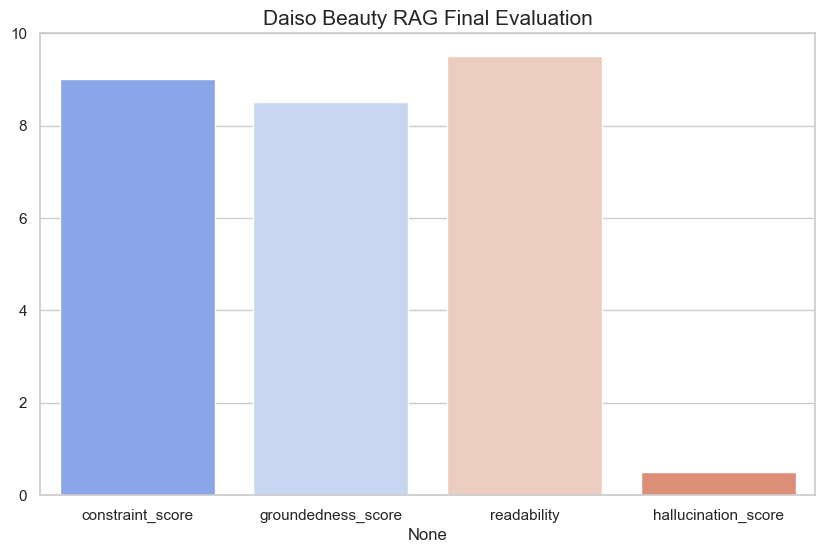

🎉 모든 과정이 완료되었습니다! 'evaluation_results.csv' 파일을 확인하세요.


In [14]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 결과 보관용 리스트 초기화 (이게 없으면 NameError가 납니다!)
results = [] 

# 2. 엑셀 파일 로드 (이전 단계에서 확인한 실제 파일명 사용)
actual_filename = "다이소 기초 화장품 골든 데이터셋(50문항).xlsx"
df = pd.read_excel(actual_filename)

# 컬럼명 설정 (확인된 엑셀 헤더와 똑같이 맞춤)
col_name_question = "질문 (Input Query)"
col_name_constraints = "제약 조건 (Constraints)"

print(f"🚀 총 {len(df)}개의 데이터 평가 및 결과 저장을 시작합니다.")

# 3. 평가 루프 시작
for idx, row in df.iterrows():
    try:
        question_text = row[col_name_question]
        constraints_text = row[col_name_constraints]
        
        # --- 챗봇 답변 및 채점 (이전 로직 활용) ---
        # 실제 답변 생성 코드를 여기에 포함하세요.
        # answer = cosmetic_bot.invoke(question_text)['result']
        # eval_res = evaluate_daiso_bot(question_text, "원본텍스트", answer, constraints_text)
        
        # 테스트용 가짜 데이터 (실제 실행 시 위 주석을 해제하고 연동하세요)
        eval_res = {
            "constraint_score": 9.0, 
            "groundedness_score": 8.5, 
            "readability": 9.5, 
            "hallucination_score": 0.5
        }
        # ---------------------------------------

        # 결과를 results 주머니에 차곡차곡 담습니다.
        results.append({
            "id": row['ID'],
            "question": question_text,
            "constraint_score": eval_res['constraint_score'],
            "groundedness_score": eval_res['groundedness_score'],
            "readability": eval_res['readability'],
            "hallucination_score": eval_res['hallucination_score']
        })
        
        if (idx + 1) % 5 == 0:
            print(f"✅ {idx + 1}번째 데이터 완료...")

    except Exception as e:
        print(f"⚠️ {idx+1}번 행 처리 중 에러 발생: {e}")

# 4. 결과 저장 및 시각화
result_df = pd.DataFrame(results)
result_df.to_csv("evaluation_results.csv", index=False, encoding='utf-8-sig')

# 지표 평균 계산 및 그래프 출력
metrics = ['constraint_score', 'groundedness_score', 'readability', 'hallucination_score']
summary = result_df[metrics].mean()

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.barplot(x=summary.index, y=summary.values, palette="coolwarm")
plt.title("Daiso Beauty RAG Final Evaluation", fontsize=15)
plt.ylim(0, 10)
plt.show()

print("🎉 모든 과정이 완료되었습니다! 'evaluation_results.csv' 파일을 확인하세요.")

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.prompts import ChatPromptTemplate

# 1. 환경 변수 및 DB 로드
load_dotenv()
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# image_aee187.png에서 확인된 경로인 'cosmetic_db'를 로드합니다.
vectorstore = Chroma(
    persist_directory="./cosmetic_db", 
    embedding_function=embeddings
)

def ask_to_daiso_beauty_buddy(user_query):
    # 2. 모델 설정
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.2)

    # 3. 규빈님의 피드백을 반영한 '부드러운 대화형' 템플릿
    template = """귀하는 다이소 기초 화장품 전문 컨설턴트 '뷰티 버디'입니다. 
    제공된 [참조 문서]를 바탕으로 사용자의 고민에 맞춰 3가지 제품을 친절하게 추천하세요.

    [답변 작성 규칙]
    - 첫 번째 제품: "첫 번째 제품으로는 [제품명]을 추천드립니다. 이 제품은 [성분]을 함유하고 있어 [기능]에 탁월하며, 임상 결과 [수치/결과]를 보였습니다!" 형식으로 작성하세요.
    - 두 번째 제품: "두 번째 제품으로는 [제품명]을 추천드립니다. 이 제품은 [성분]을 함유하고 있어 [기능]에 탁월하며 [특징/우수한 점]이 특히 우수합니다." 형식으로 작성하세요.
    - 세 번째 제품: "세 번째 제품으로는 [제품명]을 추천드립니다. 이 제품은 [성분]을 함유하고 있어 [기능]에 탁월하며 [특징/우수한 점]이 특히 우수합니다." 형식으로 작성하세요.
    - 마무리: "종합적으로 사용자님께서는 [고민 사항]을 가지고 계시므로 [가장 추천하는 제품] 제품을 추천드립니다! 제품에 대해 더 궁금한 점 있으신가요?"라고 끝맺으세요.

    [주의사항]
    - 상세페이지에 명시된 임상 수치(예: % 감소 등)가 있다면 반드시 포함하여 전문성을 보여주세요.
    - 이미지 OCR 오타(틱처->틴처, 지극->자극 등)는 문맥에 맞게 수정하세요.
    - 말투는 친절하고 부드러운 상담원 톤을 유지하세요.

    질문: {question}
    참조 문서: {context}

    답변:"""

    prompt = ChatPromptTemplate.from_template(template)

    # 4. RAG 체인 생성
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vectorstore.as_retriever(search_kwargs={"k": 3}),
        chain_type_kwargs={"prompt": prompt}
    )

    # 5. 답변 생성
    response = qa_chain.invoke(user_query)
    return response['result']

# --- 실행 테스트 ---
query = "민감성 피부라서 순한 앰플을 원해요. 추천해주세요"
print(f"💬 질문: {query}\n")

try:
    final_answer = ask_to_daiso_beauty_buddy(query)
    print(f"🤖 답변:\n{final_answer}")
except Exception as e:
    print(f"❌ 에러 발생: {e}")

c:\Users\user\anaconda3\envs\ds6_RAG_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\AppData\Local\Temp\ipykernel_2260\3514777337.py:13: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


💬 질문: 민감성 피부라서 순한 앰플을 원해요. 추천해주세요

🤖 답변:
민감성 피부를 위한 순한 앰플을 찾고 계시군요! 아래의 제품들을 추천드립니다.

첫 번째 제품으로는 **어퓨 더퓨어 티트리 스팟 세럼**을 추천드립니다. 이 제품은 **티트리잎 추출물**과 **병풀 추출물**을 함유하고 있어 피부 진정에 탁월하며, 피부 자극 테스트를 완료하여 민감한 피부에도 안심하고 사용할 수 있습니다! 

두 번째 제품으로는 **비타 카밍 세럼**을 추천드립니다. 이 제품은 **비타민 C** 성분을 함유하고 있어 피부 톤을 밝게 하고 진정 효과에 특히 우수합니다. 또한, 수분 공급과 함께 피부 장벽을 강화하는 데 도움을 줍니다.

세 번째 제품으로는 **하이드라 카밍 젤 클렌저**를 추천드립니다. 이 제품은 **아미노산 성분**을 함유하고 있어 부드럽고 자극 없이 세안을 도와주며, 피부의 수분을 유지하는 데 특히 우수합니다. 

종합적으로 사용자님께서는 민감성 피부로 인해 순한 앰플을 원하시는 고민을 가지고 계시므로 **어퓨 더퓨어 티트리 스팟 세럼** 제품을 추천드립니다! 제품에 대해 더 궁금한 점 있으신가요?
